In [1]:
import matplotlib.pyplot as plt
import random

In [2]:
from __future__ import annotations

import os
from typing import TypeVar

import cv2 as cv
import numpy as np
import pywt

In [3]:
def wavelet_dec_red_rec(
    image: np.ndarray,
    level: int = 5,
    remove_to_small_scale_layer: int = -1,
    remove_large_scale: bool = True,
) -> np.ndarray:
    # decomposition
    coeffs = pywt.wavedec2(image, 'db8', level=level)
    # reduction
    for n in tuple(range(remove_to_small_scale_layer, 0)):
        for i in tuple(range(0, 3)):
            coeffs[n][i].fill(0)
    if remove_large_scale:
        coeffs[0].fill(0)
    # reconstruction
    return pywt.waverec2(coeffs, 'db8')


T = TypeVar('T')


def iof(l: collections.abc.Sequence[T], i: int) -> T:
    # index overflow / circular linked list
    while True:
        if -1 < i < len(l):
            break
        else:
            i -= (i // len(l)) * len(l)
    return l[i]


def mash(image, struc_range_low=None, struc_range_high=None):
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # grayscale
    image_blur = cv.GaussianBlur(image_gray, (9, 9), 0, 0)  # blur

    image_b_float = image_blur.astype(np.float32) / np.iinfo(image_blur.dtype).max
    image_float = image_gray.astype(np.float32) / np.iinfo(image_gray.dtype).max

    image_b_wlred = wavelet_dec_red_rec(image_b_float)
    image_wlred = wavelet_dec_red_rec(image_float)
    # threshold
    image_b_binary = cv.threshold(
        (t := image_b_wlred),
        t.min() + (t.max() - t.min()) * 0.4,
        255,
        cv.THRESH_BINARY,
    )[1].astype(np.uint8)

    # find contours
    image_contours = cv.findContours(image_b_binary, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[0]
    image_stars: list[tuple[np.ndarray[float, float], float]] = []  # [( (x, y), intensity )]

    for c in image_contours:
        # calculate the centroid from clear image, to increase precision
        star_mask = cv.drawContours(
            np.zeros(image_wlred.shape, image_wlred.dtype),
            [c],
            0,
            1,
            cv.FILLED,
        )
        M = cv.moments(image_wlred * star_mask)
        centroid = np.array([M['m10'] / M['m00'], M['m01'] / M['m00']])
        # denote brightness from blur image, to increase robustness
        brightness = image_b_wlred[int(centroid[1]), int(centroid[0])]

        image_stars.append((centroid, brightness))
    image_stars.sort(key=lambda e: e[1], reverse=True)
    mean = np.array(tuple(e[1] for e in image_stars)).mean()
    for i in range(len(image_stars)):
        if image_stars[i][1] < mean:
            image_stars = image_stars[:i]
            break

    if struc_range_low is None:
        struc_range_low, struc_range_high = (
            np.array([0.1, 1])
            * np.array(
                tuple(np.linalg.norm(s[0] - image_stars[0][0]) for s in image_stars[1:])
            ).std()
        )

    image_structure: list[
        tuple[
            np.ndarray,  # S2A[x, y]; source star centroid
            np.ndarray,  # SNx2A[ [angle, ratio] ]; feature array
        ]
    ] = []

    for s1 in image_stars:
        neighbour: list[
            list[
                np.ndarray,  # [ S2A(separation vector) ]
                float,  # magnitude of separation vector
                float,  # angle from angle reference vector
            ]
        ] = []

        for s2 in image_stars:
            if struc_range_low < np.linalg.norm((sv := (s2[0] - s1[0]))) < struc_range_high:
                # populate separation vector and its magnitude
                neighbour.append([sv, (sr := np.linalg.norm(sv))])
                # Neighbour is already sorted by brightness because `refe_stars`
                # is sorted.  So the `neighbour[0][0]` is the angle reference vector.
                # populate angle from angle reference vector
                neighbour[-1].append(
                    np.arccos(np.clip(np.dot(neighbour[0][0], sv) / (neighbour[0][1] * sr), -1, 1))
                    * np.sign(np.cross(neighbour[0][0], sv))
                )
        # too few neighbour do not form enough triangles
        if len(neighbour) < 3:
            continue

        neighbour.sort(key=lambda e: e[2])
        feature: list[tuple[float, float]] = []  # [ (angle, ratio) ]
        for i1 in range(0, len(neighbour)):
            for i2 in range(i1 + 1, i1 + len(neighbour)):
                # here we may cross the 'PI, -PI' boundary, then `later - former`
                # becomes the clockwise angle (negative value), so we need to
                # prepare `later` to be greater
                later, former = iof(neighbour, i2)[2], neighbour[i1][2]
                if later < former:
                    later += 2 * np.pi
                angle = later - former
                # any angle less than PI is ok, but we take 4/5 PI
                if ((4 / 5) * np.pi) < angle:
                    break
                ratio = neighbour[i1][1] / iof(neighbour, i2)[1]
                feature.append((angle, ratio))

        image_structure.append((s1[0], np.array(feature)))

    return (
        image_gray,
        image_blur,
        image_wlred,
        image_b_wlred,
        image_b_binary,
        image_contours,
        image_stars,
        image_structure,
        struc_range_low,
        struc_range_high,
    )

In [4]:
# set tiff input folder
dir_input_tiff = os.path.normpath(
    os.path.join(
        os.getcwd(),
        '../',
        'input_tiff/size_full',
    )
)

# sort input files
tiff_list = os.listdir(dir_input_tiff)
tiff_list.sort()
# take the sequence middle as the reference frame
reference_tiff = tiff_list[len(tiff_list) // 2]
# and remove it from the 'to align' list
tiff_list.pop(len(tiff_list) // 2)

'__T_0523.TIF'

In [5]:
refe = cv.imread(
    os.path.join(dir_input_tiff, reference_tiff),
    cv.IMREAD_UNCHANGED,
)

In [6]:
tiff_list[0]

'__T_0498.TIF'

In [7]:
targ = cv.imread(
    os.path.join(dir_input_tiff, '__T_0498.TIF'),
    cv.IMREAD_UNCHANGED,
)

In [8]:
refe_gray, refe_blur, refe_wlred, refe_b_wlred, refe_b_binary, refe_contours, refe_stars, refe_structures, refe_struc_range_low, refe_struc_range_high = mash(refe)

In [56]:
targ_gray, targ_blur, targ_wlred, targ_b_wlred, targ_b_binary, targ_contours, targ_stars, targ_structures, _, _ = mash(targ, refe_struc_range_low, refe_struc_range_high)

In [10]:
len(refe_structures), len(targ_structures)

(124, 118)

- star match
    - star field structure
- star align
    - calculate transform matrix

## Star Match

### star field structure

- find brightest in refe
- calculate distance between brightest and all others
- cut a range in these distances
-
- for each star, find all stars within range
- calculate vector from source to target
- every two vector within angle PI form a triangle, fully characterized by the inner angle and the ratio of the two vector magnitudes (mind the order)
    - take brightest star as angle reference vector
    - for each vector, calculate angle from angle ref. vector (anticlockwise)
    - sort vectors by angle
    - (2 layer) iterate the list, take the anticlockwise angle (later minus former), ratio be the former divided by the later
- so the structure feature array `Sn` would be of the form: `[ Vector1Triangle0, V1T1, V1T2, V2T0, V2T1, V3T0, ... ]`, with each `VnTn` of the form: `[angle, ratio]`
-
- pick 2 structures if categorized as similar, treat the source as the same star
    - pick `S1[i1]` as start, iterate `S2` untile find a match `S2[i2]`
    - pick `S1[i1+1]`, start at `S2[i2+1]`, find match at `S2[i2+n1]`
    - do the same for `S1[i1+2]`, start at `S2[i2+n1+1]`, find match at `S2[i2+n1+n2]`

#### test area

In [11]:
refe_stars[2], targ_stars[7]

((array([3453.97849113, 1300.13092681]), 0.3607522),
 (array([3383.13345438, 1268.1062361 ]), 0.34451726))

In [12]:
refe_structures[2][0], targ_structures[7][0]

(array([3453.97849113, 1300.13092681]), array([3383.13345438, 1268.1062361 ]))

okay ... by eyeball 2 and 7 are the same star, how to get this result from the feature array?

In [13]:
refe_structures[2][1].shape, targ_structures[7][1].shape

((120, 2), (123, 2))

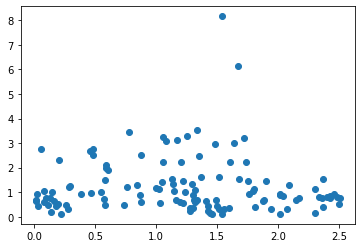

In [14]:
plt.scatter(*refe_structures[2][1].T)

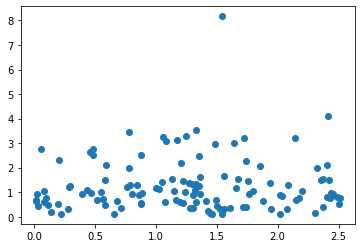

In [15]:
plt.scatter(*targ_structures[7][1].T)

try to represent 'correlation'

In [16]:
distance = []
for r in refe_structures[2][1]:
    for t in targ_structures[7][1]:
        distance.append(np.linalg.norm(r - t))

In [17]:
t = np.array(distance)

find the characteristic of matched star feature array

In [18]:
t.std(), t.shape

(1.1042771166972114, (14760,))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2., 25., 23., 21.,  9.,  3.,  0.,  3.,  2.,  0.,
         2.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,  1.,
         2.,  1.,  0.,  1.,  1.,  2.,  1.,  0.,  0.]),
 array([-0.01  , -0.0094, -0.0088, -0.0082, -0.0076, -0.007 , -0.0064,
        -0.0058, -0.0052, -0.0046, -0.004 , -0.0034, -0.0028, -0.0022,
        -0.0016, -0.001 , -0.0004,  0.0002,  0.0008,  0.0014,  0.002 ,
         0.0026,  0.0032,  0.0038,  0.0044,  0.005 ,  0.0056,  0.0062,
         0.0068,  0.0074,  0.008 ,  0.0086,  0.0092,  0.0098,  0.0104,
         0.011 ,  0.0116,  0.0122,  0.0128,  0.0134,  0.014 ,  0.0146,
        

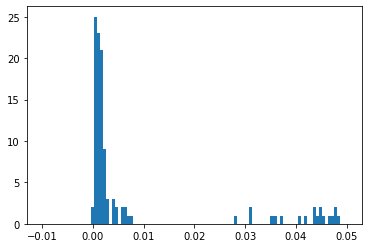

In [19]:
plt.hist(t, bins=100, range=(-0.01, 0.05))

find an appropriate function to 'weight' distance

In [20]:
x = np.linspace(0, 0.1, 1000)

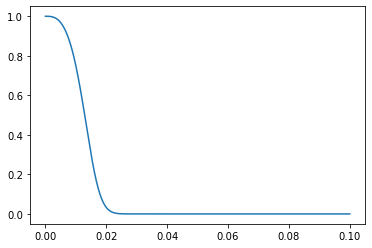

In [21]:
y = 2 / ( 1 + np.exp(np.power((80*x), 3)) )
plt.plot(x, y)

test run

In [22]:
score = 2 / ( 1 + np.exp(np.power((80*t), 3)) )

<ipython-input-22-744bd4d808c6>:1: RuntimeWarning: overflow encountered in exp
  score = 2 / ( 1 + np.exp(np.power((80*t), 3)) )


In [23]:
score.sum() / (len(refe_structures[2][1]) + len(targ_structures[7][1]))

0.3842263545831961

---
---

In [32]:
# def score_feature_correlation(
#     f1: np.ndarray,
#     f2: np.ndarray,
#     weight_cliff_coeff: int = 80,
# ) -> float:
#     separation: list[float] = []
#     for triangle_1 in f1:
#         for triangle_2 in f2:
#             separation.append(np.linalg.norm(triangle_2 - triangle_1))
#     s = np.array(separation)
#     normalized_separation = 2 / (1 + np.exp(
#         np.power( (weight_cliff_coeff * s), 3 )
#     ))
#     return normalized_separation.sum() / (len(f1) + len(f2))

def score_feature_correlation(
    # the order of `f1` and `f2` does not matter
    f1: np.ndarray,  # f1: SNx2A[ [angle, ratio] ]
    f2: np.ndarray,  # f2: SMx2A[ [angle, ratio] ]
    weight_cliff_coeff: int = 80,
) -> float:
    # prepare `f1` and `f2` to be in the 'cartesian product' shape 'S NMx2 A'
    f1e = np.repeat(f1, len(f2), axis=0)
    f2e = np.tile(f2, (len(f1), 1))

    separation = np.linalg.norm(f2e - f1e, axis=1)
    # normalized_separation = 2 / (
    #     1 + np.exp(np.power(weight_cliff_coeff * separation, 3))
    # )
    normalized_separation = np.divide(
        2,
        np.add(
            1,
            np.exp(
                np.power(
                    np.multiply(weight_cliff_coeff, separation),
                    3
                )
            )
        )
    )

    return normalized_separation.sum() / (len(f1) + len(f2))

test robustness and pick threshold

In [25]:
tsl = []

In [26]:
for source in refe_structures:
    for target in targ_structures:
        tsl.append(score_feature_correlation(source[1], target[1]))

<ipython-input-24-a80cf154c176>:33: RuntimeWarning: overflow encountered in exp
  np.exp(


(array([1.359e+03, 1.409e+03, 1.623e+03, 1.593e+03, 1.387e+03, 1.193e+03,
        1.004e+03, 8.440e+02, 7.790e+02, 6.550e+02, 5.790e+02, 5.240e+02,
        4.360e+02, 3.290e+02, 2.410e+02, 1.660e+02, 1.280e+02, 9.100e+01,
        6.600e+01, 3.600e+01, 3.400e+01, 2.100e+01, 1.500e+01, 1.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

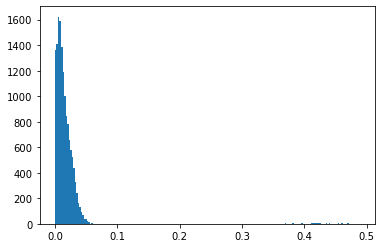

In [27]:
plt.hist(tsl, bins=200)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 2., 0., 0., 0., 1., 1., 0., 0., 4.,
        1., 1., 1., 0., 2., 1., 1., 1., 2., 0., 2., 2., 2., 1., 2., 0., 1.,
        0., 0., 3., 5., 4., 2., 7., 3., 3., 4., 3., 3., 1., 2., 6., 3., 2.,
        3., 2., 2., 0., 0., 0., 0., 2., 1., 1., 2., 1., 0., 0., 3., 2., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.]),
 array([0.1  , 0.102, 0.104, 0.106, 0.108, 0.11 , 0.112, 0.114, 0.116,
        0.118, 0.12 , 0.122, 0.

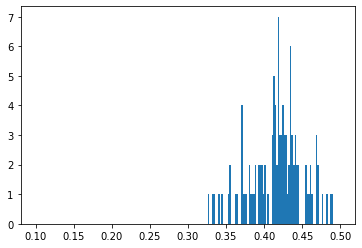

In [28]:
plt.hist(tsl, bins=200, range=(0.1, 0.5))

In [57]:
(len(refe_structures),
 len(targ_structures),
 len(tsl),
 len(tuple(e for e in tsl if 0.3 < e)))

(124, 118, 14632, 108)

---

In [59]:
def find_star_pair(
    reference_structures: list[tuple[
        np.ndarray,  # S2A[x, y]; star centroid
        np.ndarray,  # SNx2A[ [angle, ratio] ]; feature array
    ]],
    viewing_structures: list[tuple[np.ndarray, np.ndarray]],
    match_score_threshold: float = 0.3,
) -> list[tuple[
    np.ndarray, np.ndarray  # star centroid
]]:
    vs = viewing_structures.copy()
    refe_view_star_pair: list[tuple[np.ndarray, np.ndarray]] = []
    for r in reference_structures:
        match_list = []
        for iv in range(len(vs)):
            score = score_feature_correlation(r[1], vs[iv][1])
            if match_score_threshold < score:
                match_list.append( (vs[iv], iv, score) )
        if len(match_list) == 0:
            continue
        # sort `match_list` by score, descending
        match_list.sort(key=lambda e: e[2], reverse=True)
        # select highest score match
        refe_view_star_pair.append( (r[0], match_list[0][0][0]) )
        # remove selected match from search list
        vs.pop(match_list[0][1])
    return refe_view_star_pair

In [60]:
refe_targ_star_pair = find_star_pair(refe_structures, targ_structures)

<ipython-input-32-a32a4e6c6080>:34: RuntimeWarning: overflow encountered in exp
  np.exp(


In [61]:
len(refe_targ_star_pair)

108

## Star Align

## Image Debug Area

In [ ]:
def cvshow(name: str, image: np.ndarray):
    cv.namedWindow(name, cv.WINDOW_NORMAL)
    cv.resizeWindow(name, 1000, 1000)
    cv.moveWindow(name, 130, 20)
    cv.imshow(name, image)

In [ ]:
rtimg = cv.cvtColor(
    (refe_gray * (np.iinfo(np.uint8).max / np.iinfo(np.uint16).max)).astype(np.uint8),
    cv.COLOR_GRAY2BGR,
)
for c in tuple(e[0] for e in refe_stars):
    cv.drawMarker(rtimg, tuple(int(e) for e in c), (0, 0, 255))

In [ ]:
ttimg = cv.cvtColor(
    (targ_gray * (np.iinfo(np.uint8).max / np.iinfo(np.uint16).max)).astype(np.uint8),
    cv.COLOR_GRAY2BGR,
)
for c in tuple(e[0] for e in targ_stars):
    cv.drawMarker(ttimg, tuple(int(e) for e in c), (0, 0, 255))

In [ ]:
# cvshow('refe_photo', refe_photo)
# cvshow('refe_photo_g', refe_photo_g)
# [1844:2044, 1844:2044]
# [1744:2144, 1744:2144]
# [1444:2444, 1444:2444]


# cvshow('refe gray', refe_gray)
cvshow('refe wlred', refe_wlred)
cvshow('rtimg', rtimg)

# cvshow('targ gray', targ_gray)
cvshow('targ wlred', targ_wlred)
cvshow('ttimg', ttimg)


cv.waitKey(0)
cv.destroyAllWindows()

In [ ]:
# [2500:2550, 125:175]
# cvshow('refe gray', refe_gray[1175:1425,3325:3575])
cvshow('refe wlred', refe_wlred[1175:1425,3325:3575])
cvshow('rtimg', rtimg[1175:1425,3325:3575])

# cvshow('targ gray', targ_gray[1140:1390,3260:3510])
cvshow('targ wlred', targ_wlred[1140:1390,3260:3510])
cvshow('ttimg', ttimg[1140:1390,3260:3510])


cv.waitKey(0)
cv.destroyAllWindows()

In [ ]:
cv.waitKey(0)
cv.destroyAllWindows()